In [ ]:
### TOMORROW:
# introduce actual exploration using the search tree (we're about to get much slower!)
# introduce visit counts into the equation (again, slower!)
# stop training on the immediate finish ones? Try and balance for game length too?
# figure out how to keep it running continually
# figure out the best learning parameters that will prevent it going off the deep end.
# make sure the visit count permutations are running correctly for the augmentations
# make sure you have a sensible and nice way to save things down

In [11]:
# todo
# look into increasing network size and comparing ability then
# change the lr to be a schedule that goes up and down, maybe just with sgd
# really, want the network to have a 100% hit on 1 move wins?

from importlib import reload
import random
import torch
import os
import numpy as np
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import datetime
import pickle

import trainer
reload(trainer)

import mcts.networks
reload(mcts.networks)

import augmentor
reload(augmentor)

from trainer import PatternTrainer
from mcts.networks import PatternsNet
from plotting import PatternPlotter
from augmentor import StateAugmentor

my_device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# rseed = 12387623
# random.seed(rseed)
# torch.manual_seed(rseed)
# np.random.seed(rseed)


In [ ]:
### Load saved games to investigate:

_lstrings = [
    '2025_07_01_23_03',
    '2025_07_01_23_23',
            ]

load_string = os.path.join(Path.cwd(), 'saved_games', _lstrings[0] +'.pkl')

saved_games = pickle.load(open(load_string, 'rb'))
len(saved_games[-1]), len(saved_games[0]), len(saved_games[1])

In [ ]:
### Testing for the augmentor:

_check = random.choice(saved_games[1])

check_tensor = _check[0]
check_visit_counts = _check[1]
check_distance_from_terminal = _check[2]
check_flipped = _check[3]
check_nod_result = _check[4]

# use augmentor to create a non-augmented game:
paug = StateAugmentor(check_tensor)
recreated_game = paug.create_game_from_state()
paug.full_augment()
aug_game_1 = paug.create_game_from_state()

for it in range(5):
    paug.full_augment()
    
aug_game_2 = paug.create_game_from_state()

pplotter_1 = PatternPlotter(recreated_game)
pplotter_2 = PatternPlotter(aug_game_1)
pplotter_3 = PatternPlotter(aug_game_2)

pplotter_1.plot()
pplotter_2.plot()
pplotter_3.plot()
check_nod_result, check_tensor[-10:, 0, 0]

print(aug_game_1.calculate_score(), aug_game_2.calculate_score(), recreated_game.calculate_score())


In [ ]:
### Create a fresh network and assign to a trainer:

my_network = PatternsNet(
    in_channels=47, 
    out_channels=128,
).float()

my_trainer = PatternTrainer(network=my_network,
                            device=my_device)

# sum(p.numel() for p in my_network.parameters() if p.requires_grad)

# print([(name, p.dtype) for name, p in my_network.named_parameters()])



_epoch=300, _bsize=512, _lr=0.002

2025_07_01_23_03.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_01_23_23.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_01_23_43.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_03.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_22.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_42.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_01_02.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_06_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_07_18.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_07_37.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299


_epoch=300, _bsize=512, _lr=0.001

2025_07_01_23_03.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_01_23_23.pkl
Current epoch: 99

Current 

C:\Users\Danie\AppData\Local\Temp\ipykernel_62848\622266580.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


2025_07_01_23_23.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_01_23_43.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_03.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_22.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_00_42.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_01_02.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_06_58.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_07_18.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299

2025_07_02_07_37.pkl
Current epoch: 99

Current epoch: 199

Current epoch: 299



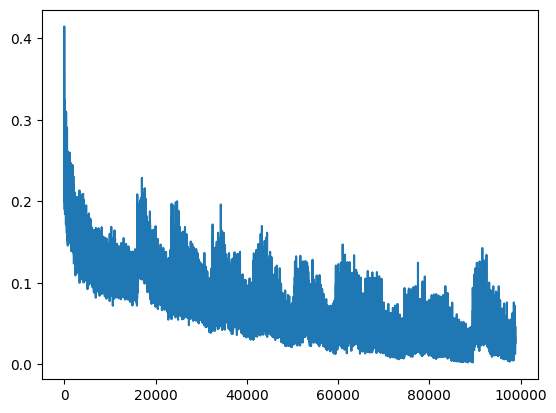

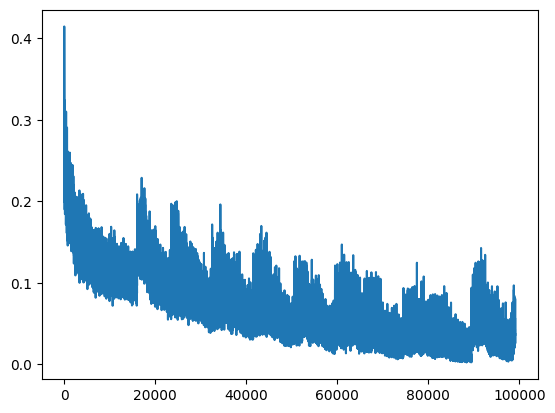

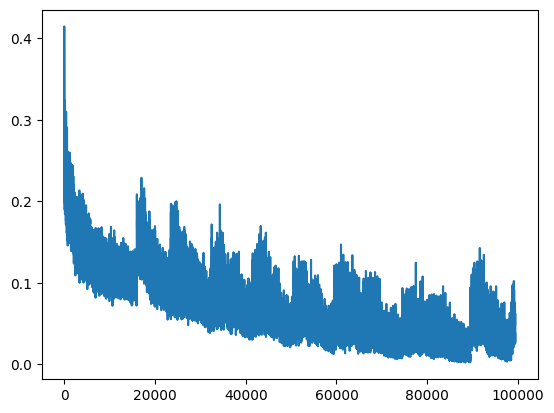

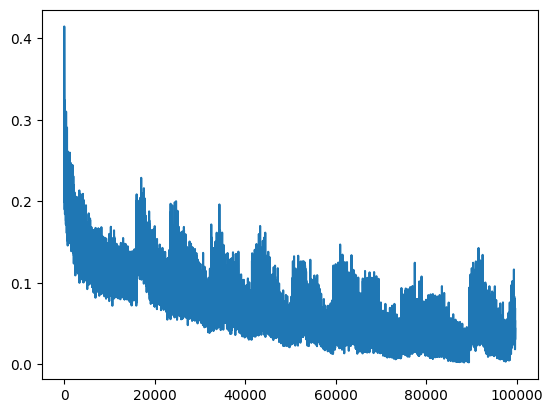

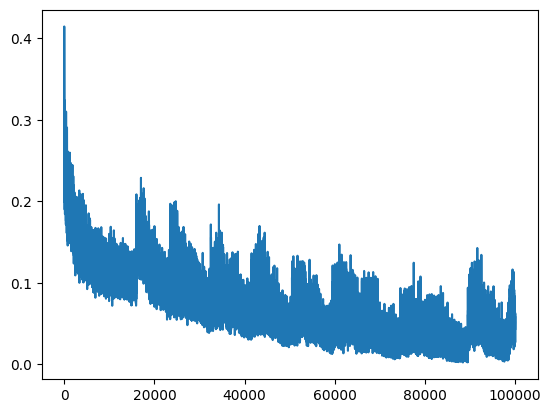

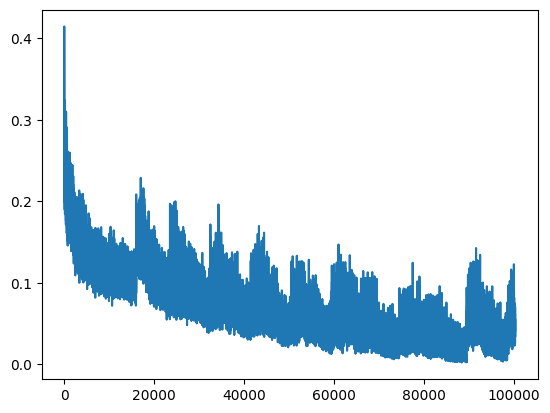

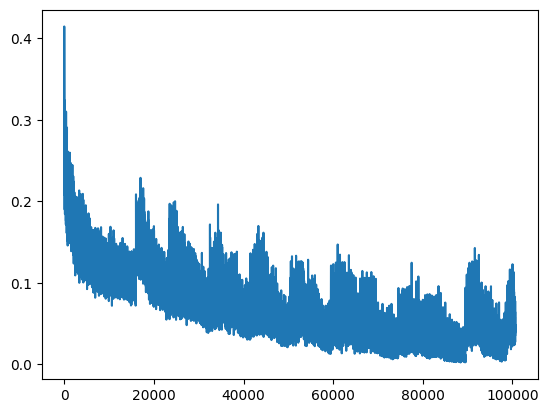

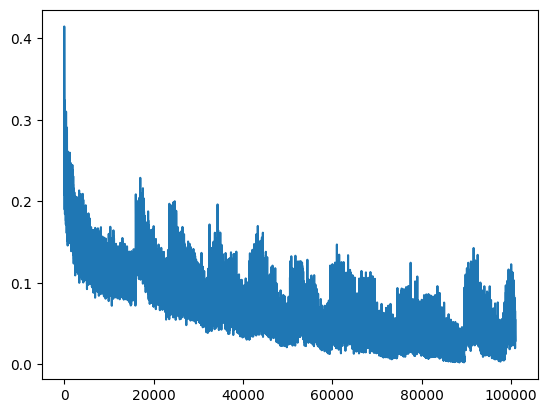

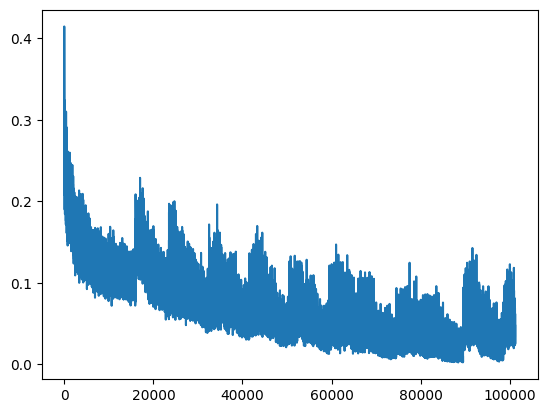

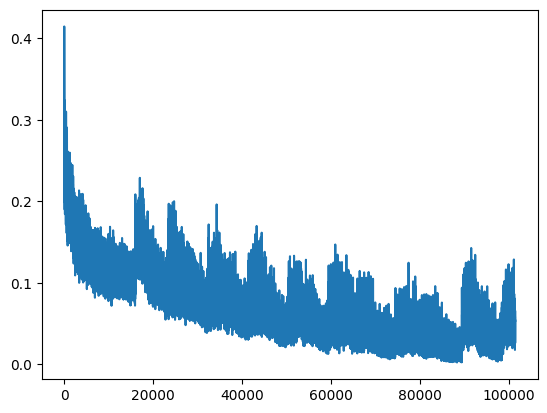

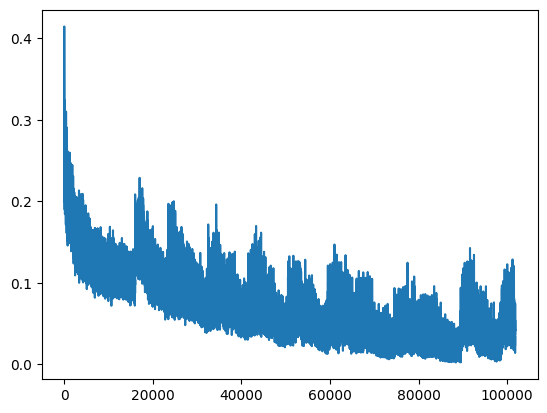

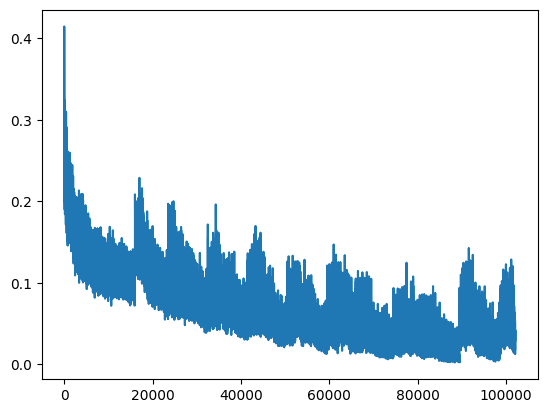

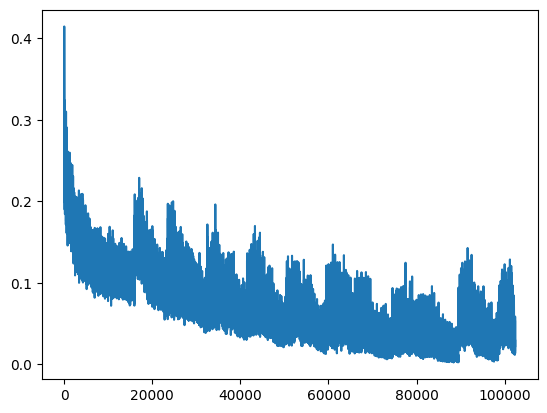

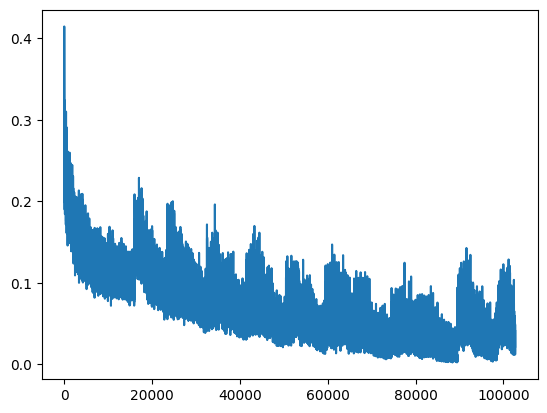

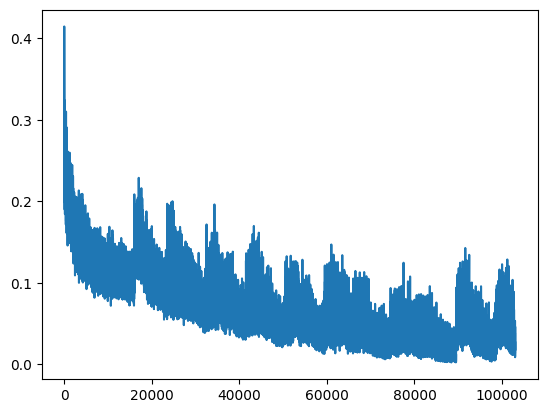

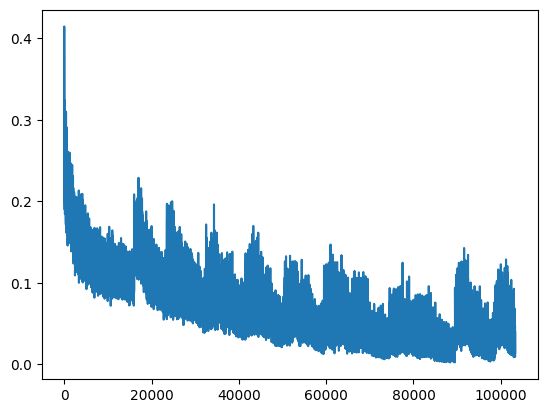

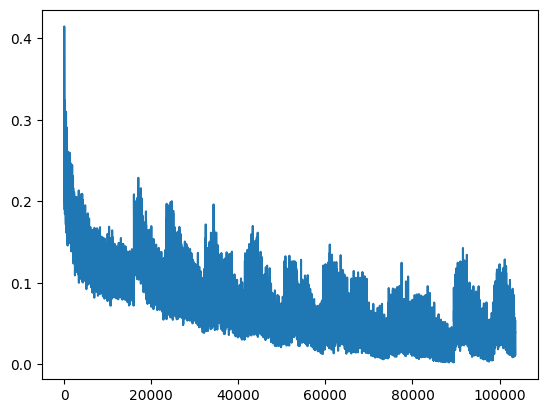

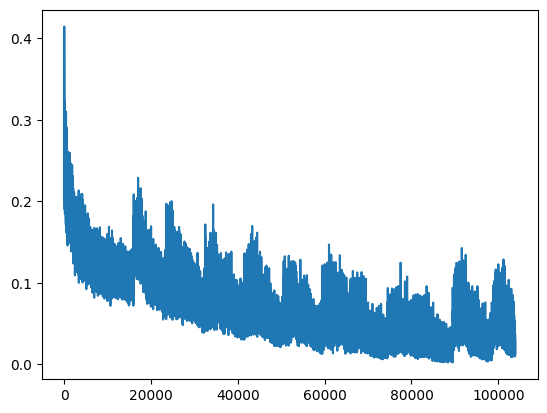

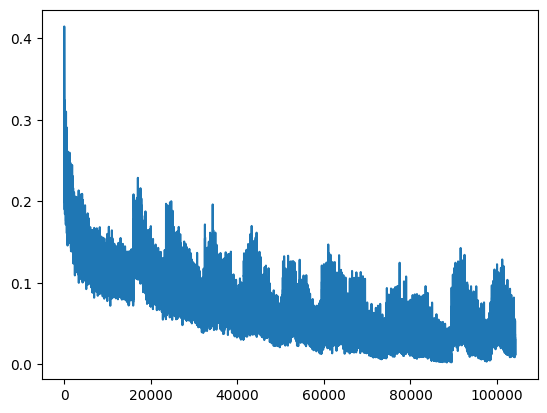

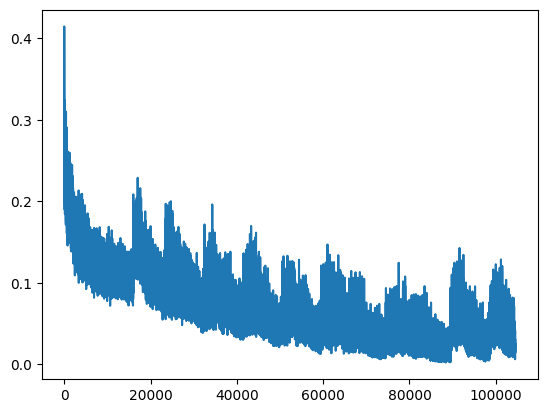

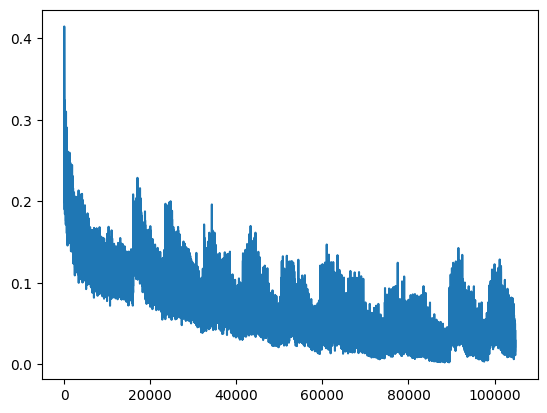

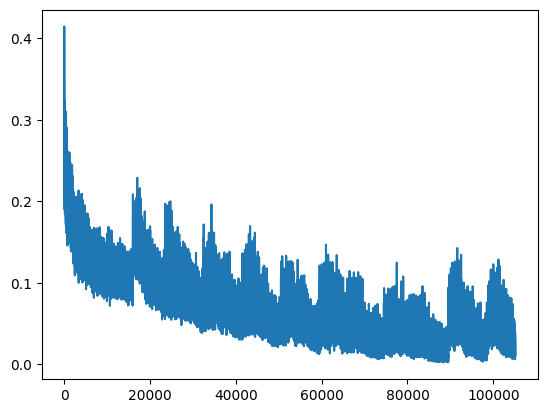

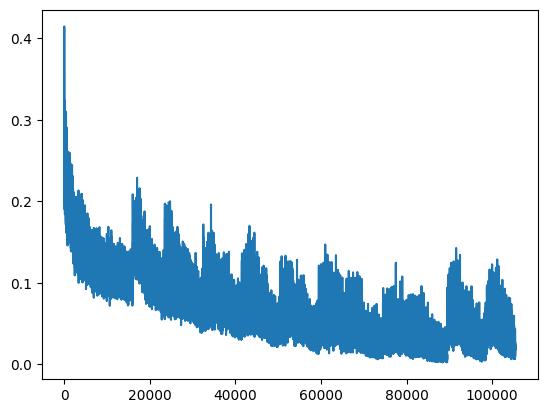

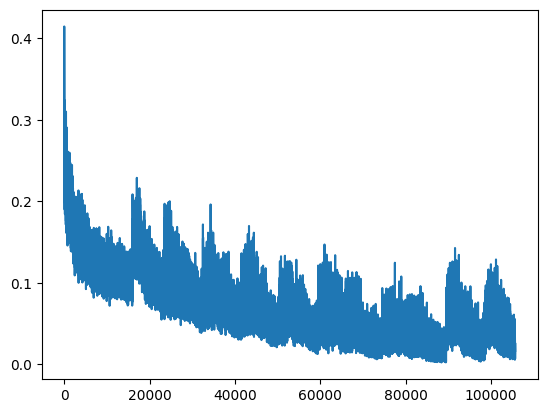

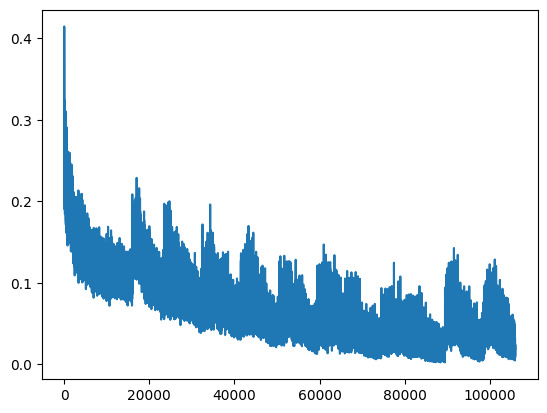

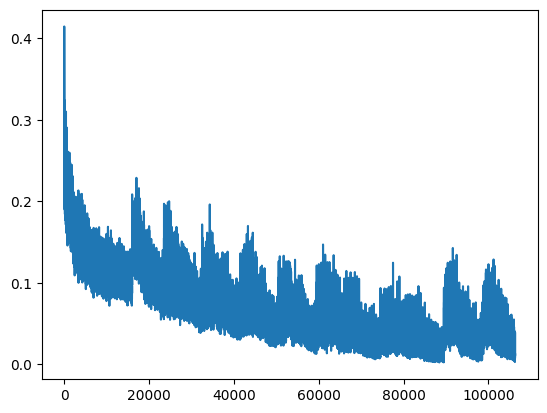

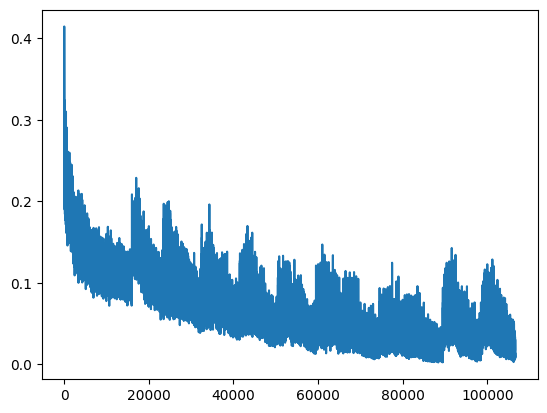

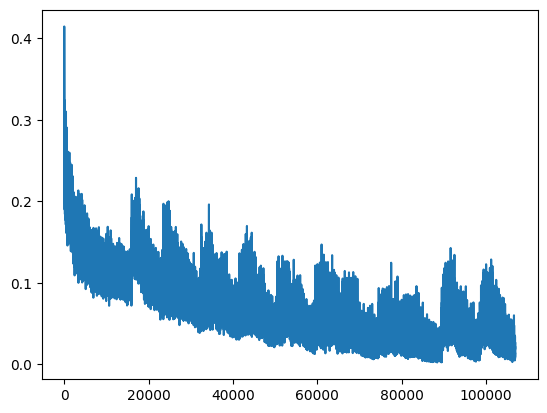

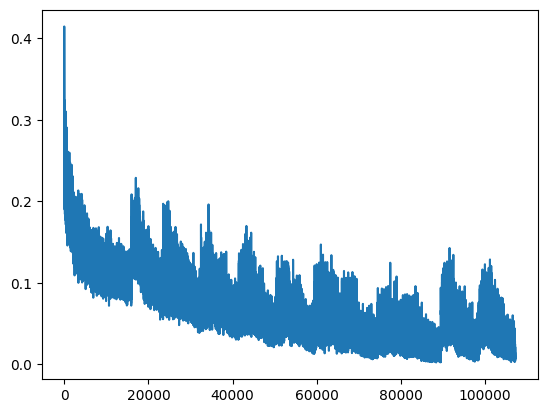

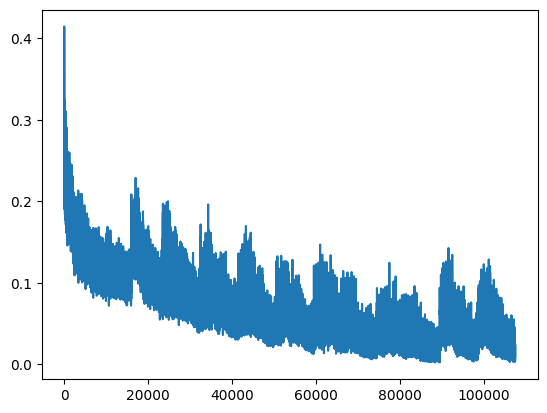

In [23]:
### Train the network on various saved games:
load_paths = [
    "2025_07_01_23_03.pkl",
    "2025_07_01_23_23.pkl",
    "2025_07_01_23_43.pkl",
    "2025_07_02_00_03.pkl",
    "2025_07_02_00_22.pkl",
    "2025_07_02_00_42.pkl",
    "2025_07_02_01_02.pkl",
    "2025_07_02_06_58.pkl",
    "2025_07_02_07_18.pkl",
    "2025_07_02_07_37.pkl",
  ]
          
is_augment = True
epoch_list = [300, 300, 300]
batch_size_list = [512, 512, 512]
is_include_policy = False
is_plot_losses = False
learning_rate_list = [2e-3, 1e-3, 5e-4]

for _epoch, _bsize, _lr in zip(epoch_list, batch_size_list, learning_rate_list):
    print(f"\n{_epoch=}, {_bsize=}, {_lr=}\n")
    
    for _load_path in load_paths:
        print(_load_path)
        
        data_location = os.path.join(Path.cwd(), 'saved_games', _load_path)
        
        my_trainer.train(data_location=data_location,
                         is_augment=is_augment,
                         epochs=_epoch,
                         batch_size=_bsize,
                         is_include_policy=is_include_policy,
                         is_plot_losses=is_plot_losses,
                         learning_rate=_lr,
                        )
        
        fig, ax = plt.subplots()
        ax.plot(my_trainer.losses)

# save the network after training iterations finish:
save_string = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
save_path = os.path.join(Path.cwd(), 'saved_networks', save_string + '.pt')
torch.save(my_network.state_dict(), save_path)

22.393857713249183 22.497788384144215 14.127306724499398
19.56557764578601 20.43050010334197 14.616699993540673
16.452317206250253 17.181195576714458 12.763052448865828
15.721603710887369 15.280264918242736 12.419621945830064
12.798479848239058 16.071432872953295 12.986594110347564
14.090201664950873 13.481639668612155 14.350594942207536
13.176400236534992 14.829167384660058 14.937428494206467
12.581049495033566 15.360734974443057 14.856397264237772
11.338771263441574 15.927003762558074 16.91957275284077
12.08788415560701 17.014827769145118 19.21659191389452


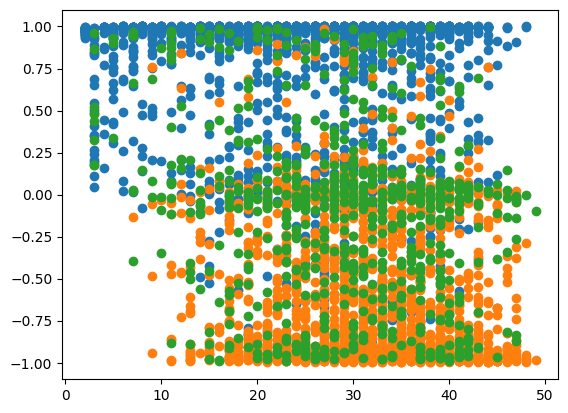

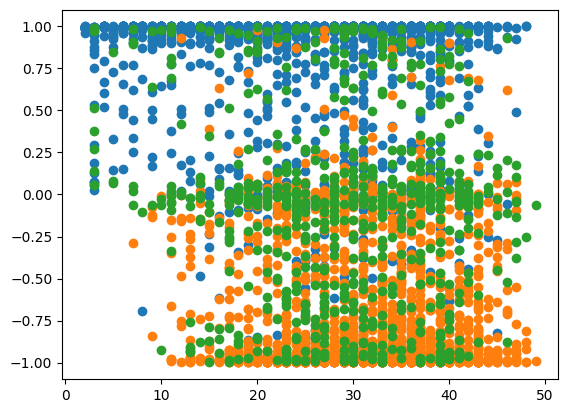

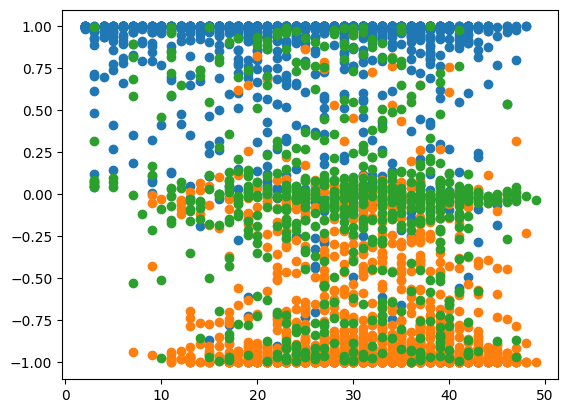

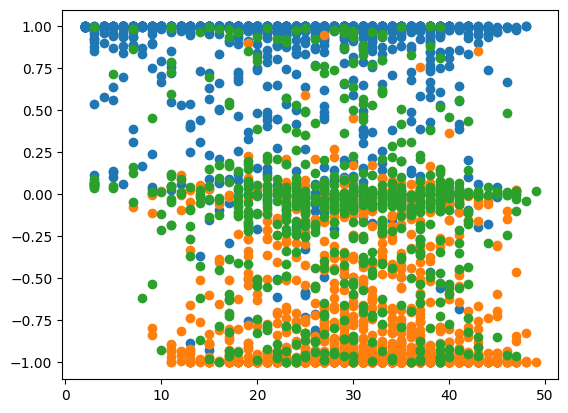

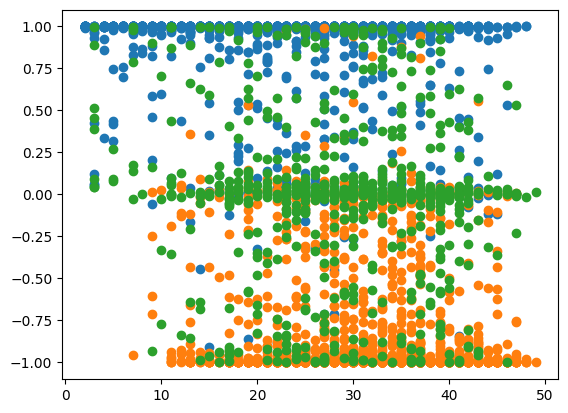

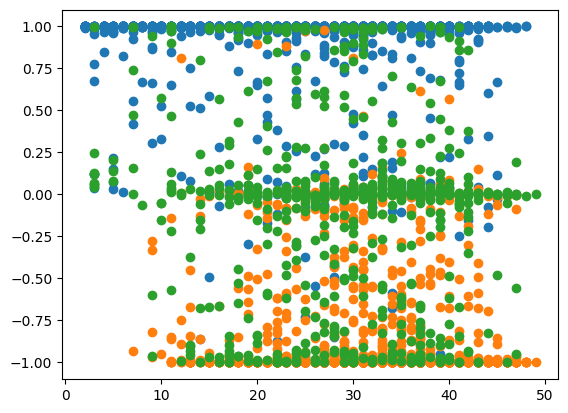

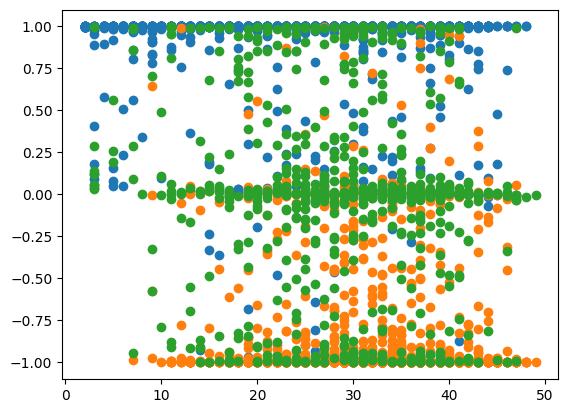

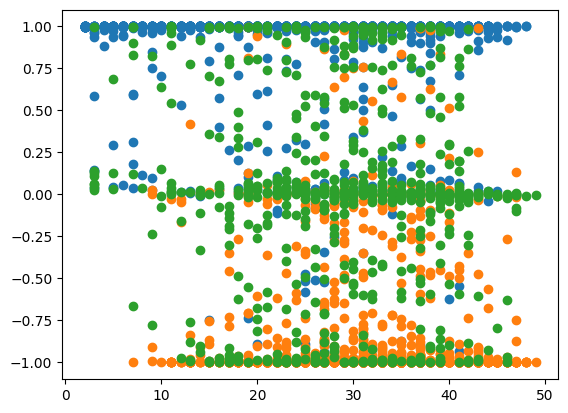

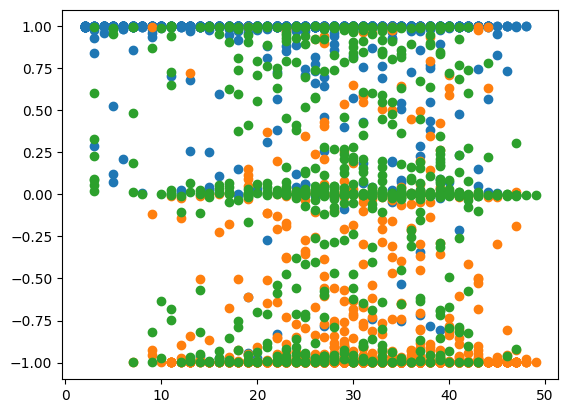

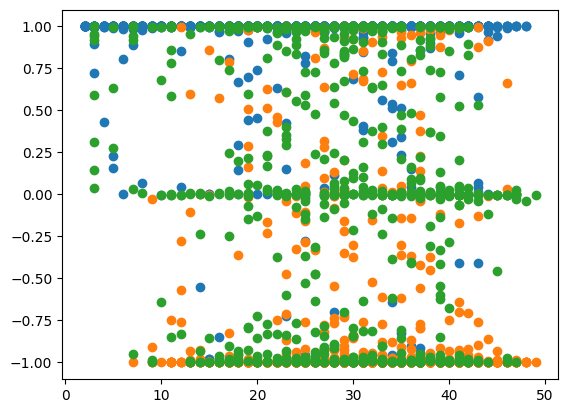

In [21]:
### load a network and assess the accuracy

# save location for the state dictionary:
npaths = ["2025_07_02_17_49",
          "2025_07_02_19_04",
          "2025_07_03_12_18",
          "2025_07_03_13_28",
          "2025_07_03_15_17",
          "2025_07_03_16_37",
          "2025_07_03_17_44",
          "2025_07_03_21_08",
          "2025_07_03_22_57",
          "2025_07_04_13_54"
         ]

# todo need some way to get the meta characteristics in a file so that can always be loaded if the 
# architecture changes:

# path locations:
nlocs = [os.path.join(Path.cwd(), 'saved_networks', network_path + '.pt') for network_path in npaths]

# create shell networks:
nets = [PatternsNet(in_channels=47, out_channels=128) for _ in npaths]

# populate each network with different saved instance:
for _net, _nloc in zip(nets, nlocs):
    _net.load_state_dict(torch.load(_nloc, weights_only=True))

# assign to trainer class: (do we want to avoid assigning the network?)
ts = [PatternTrainer(network=_net, device=my_device) for _net in nets]

# string and data path for the validation games:
valid_path = "VALID_2025_07_02_07_57.pkl"
dloc = os.path.join(Path.cwd(), 'saved_games', valid_path)

# assess the losses for the network in question:
for _t in ts:
    _win_acc, _loss_acc, _draw_acc = _t.validate_value(data_location=dloc,
                                                       num_check=2000,
                                                       is_augment=True,
                                                       is_plot=True)
    
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
fig, ax = plt.subplots()
ax.plot(my_trainer.losses)

In [ ]:
fig, ax = plt.subplots()
ax.set_ylim([0., 0.55])
ax.plot(my_trainer.losses)

In [ ]:
load_strings = ["2025_06_05_09_26", "2025_06_05_14_15", "2025_06_05_19_20"]

network_load_locations = [os.path.join(Path.cwd(), 'saved_networks', _ls + '.pt') for _ls in load_strings]

nets = [PatternsNet(in_channels=103, out_channels=128) for _ in range(len(load_strings))]

for net, load_location in zip(nets, network_load_locations):
    net.load_state_dict(torch.load(load_location, weights_only=True))

validation_data_location = os.path.join(Path.cwd(), 'saved_games', '2025_05_30_11_27.pkl')

vtrainers = [PatternTrainer(network=_net, device=my_device) for _net in nets]

In [ ]:
for _vt in vtrainers:
    _win_acc, _loss_acc, _draw_acc = _vt.validate_value(data_location=validation_data_location,
                                                        num_check=2000,
                                                        is_augment=True,
                                                        is_plot=True)
    print(_win_acc, _loss_acc, _draw_acc)


In [ ]:
win1, loss1, draw1 = vtrainer1.validate_value(data_location=validation_data_location,
                                              num_check=2000,
                                              is_augment=True,
                                              is_plot=True)


In [ ]:
win1, win2, loss1, loss2, draw1, draw2

In [ ]:
# set network to eval mode:
validation_trainer.network.eval()

# split the data set:
wins = validation_games[1]
losses = validation_games[-1]
draws = validation_games[0]

In [ ]:
predictions = []
num_required = 1000
game_list = wins
batch_size = 2048
is_augment = True

while len(predictions) < num_required:
    print('HI')
    # collect sample of games:
    sample_games = game_list[:batch_size]

    # get the states from the games:
    _states, _vcs, _, _, _ = zip(*sample_games)

    # stack the tensors:
    state_tensor = torch.stack(_states)
    vc_tensor = torch.tensor(np.stack(_vcs))

    # augment the states:
    states, visit_counts = validation_trainer.augment_sample(state_tensor, vc_tensor, is_augment=is_augment)

    # get the predicted results and the policy vectors for the states considered:
    with torch.no_grad():
        # do not collect the prior policy here:
        value_predictions, _ = validation_trainer.network(states.to(validation_trainer.device))

    # return the value predictions locally:
    predictions.append(value_predictions.cpu())

    # trim the wins list:
    game_list = game_list[batch_size:]

    if batch_size * num_required >= num_required:
        break


In [ ]:

# turn the list of tensors into a single tensor:
predictions = torch.stack(predictions)

In [ ]:
len(game_list), num_required

In [ ]:
win_accuracy = ((win_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(win_predictions)
loss_accuracy = ((loss_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(loss_predictions)
draw_accuracy = ((draw_predictions.numpy() - 1.0) ** 2.0).sum() ** 0.5 / len(draw_predictions)

In [ ]:
import numpy as np

In [ ]:
my_args = np.argsort(np.random.rand(5))[:3]
my_args

In [ ]:
np.random.sample([0, 1, 2, 3, 4], k=2)

In [ ]:
import torch

my_arr = torch.zeros((8, 8, 12), dtype=float)

active_order = [0, 0, 1, 3, 2, 4]
passive_order = [3, 0, 1, 0, 0, 2]

vals = torch.tensor(active_order + passive_order, dtype=float) / 6.0

# inds = np.array(range(12))
inds = range(12)

my_arr[:, :, inds] = vals



In [ ]:
my_arr[:, :, 3]

In [ ]:
d1 = {1: [1, 2, 3], 2: [4, 5, 6]}

d2 = dict(d1)
d3 = {_key: _val[:] for _key, _val in d1.items()}

d2[1].append(0)
d2[1][0] *= 1000

d3[2].append(7)
d3[2][0] *= 10

d1, d2, d3

In [ ]:
jim = np.array([0, 1, 2, 3, 4, 5, 6])

peack = jim / 6.

for _ in peack:
    print(round(_ * 6))